# CartPole


Note: This example follows the book "A. Geron (2019), Hands-on Machine Learning with Scikit-learn, Keras & TensorFlow" O'Reilly.

An episode ends when either:
   * the angle of the pole is more than $\pm 12^\circ$
   * the cart reaches the either end of the environment
   * episode length is larger than 500 steps (for v1)

The reward we obtain from the environment is quite simple: For each interaction where the pole does not tip over, we obtain a constant reward of 1.

In [1]:
# required imports

import gym
import numpy as np
import random

# for replay buffer
from collections import deque

import matplotlib.pyplot as plt
%pylab inline
# large figures
rcParams['figure.figsize'] = 8, 6

# TensorFlow
import tensorflow as tf
from tensorflow.keras import layers


#
# for animations
#
# clear the output of the cell to avoid long output lists
# see http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output
from IPython.display import clear_output

# for the animation at the end
from matplotlib import animation
from IPython.display import display
import time


#check if running in Google Colab
import sys
in_colab = 'google.colab' in sys.modules
if in_colab:
  print('Running in Google Colaboratory')


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Running in Google Colaboratory


If we run the notebook locally, we have have a display accessible already
(although you might need to run am X11 server if you are on a Windows machine, 
you will have one running anyway on Linux).

However, if we connect to the notebook remotely via a server, for 
example via myBinder or in Google's Colaboratory, we don't have access
to the graphics output.
We can still access the graphics output by creating a virtual display
using the python package ```pyvirtualdisplay``` which is a python
wrapper around the special X server [Xvfb](https://www.x.org/releases/X11R7.6/doc/man/man1/Xvfb.1.xhtml) that can run without graphics hardware.

If we then want to render the OpenAI gym environment, we can create 
an RRB image and display this.

Running the notebook within Google's Colaboratory requires
the installation of some non-default packages as well as
the X-server. This is already done in other environments.
See [D. Pugh's post](https://davidrpugh.github.io/stochastic-expatriate-descent/openai/binder/google-colab/2020/04/16/remote-rendering-gym-envs.html)
for more details

In [2]:
if in_colab:
  print('Setting up graphics environment')
  !apt-get install -y xvfb x11-utils
  !pip3 install pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*
  # we need an updated version of pyglet to display the graphics
  # this will give (at the moment) a compatibilty warning from OpenAI gym - 
  # but it still works.
  !pip3 install pyglet==1.5.5
###

#setup virtual display
import pyvirtualdisplay
_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = _display.start()
!echo $DISPLAY

Setting up graphics environment
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 31 not upgraded.
Need to get 993 kB of archives.
After this operation, 2,977 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.4 [784 kB]
Fetched 993 kB in 1s (795 kB/s)
Selecting previously unselected package libxxf86dga1:amd64.
(Reading database ... 144433 files and directories currently installed.)
Preparing to unpack .../libxxf86dga1_2%3a1.1.4-1_amd64.deb ...
Un

We can now initialize the environment and have a look at what it looks like.

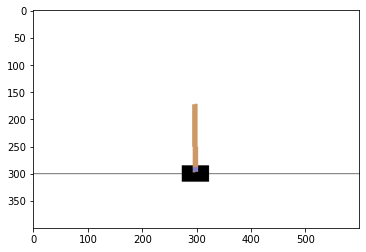

In [3]:
env = gym.make('CartPole-v1') 
state = env.reset()
plt.imshow(env.render(mode='rgb_array'))
plt.show()

Each state is represented by an array of four numbers:
   * the $x$ position of the cart, 0.0 represents the center.
   * velocity of the cart (positive towards right)
   * angle of the pole (0.0 represents horizontal)
   * angular velocity (positive is clock-wise)

In [4]:
print(state)

[-0.01689633 -0.04950403 -0.00930926  0.02754969]


There are two possible actions:
   * push cart to the left
   * push cart to the right


In [5]:
print(env.action_space)

Discrete(2)


Let's try an action manually and push the cart to the right

new state  [-0.01788641  0.14575018 -0.00875826 -0.26805581]
reward     1.0
done       False
debug info {}


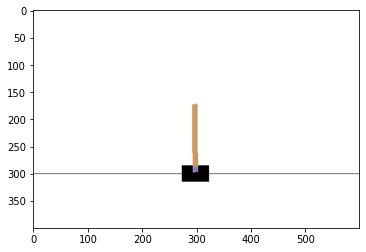

In [6]:
action = 1
next_state, reward, done, info = env.step(action)
print('new state  {}'.format(next_state))
print('reward     {}'.format(reward))
print('done       {}'.format(done))
print('debug info {}'.format(info))
plt.imshow(env.render(mode='rgb_array'))
plt.show()

Let's look at a small animation of the cart if we push it
around choosing whether to push left or right at random. We will soon notice that the pole starts to fall over and the episode ends.

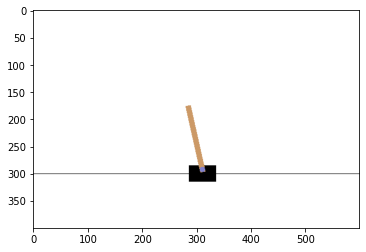

Timestep: 20
State   : [ 0.08588256  0.23579649 -0.22036075 -0.93421148]
Action  : 1
Reward  : 1.0
Done    : True


In [7]:
frames = []
state  = env.reset()

for i in range(0,100):

  #choose action at random
  action = env.action_space.sample() # choose random action
  new_state, reward, done, info = env.step(action)
  state = new_state



  frames.append({
      'frame'  : env.render(mode='rgb_array'),
      'state'  : state,
      'action' : action,
      'reward' : reward,
      'done'   : done
  })

  if done:
    break

for i, frame in enumerate(frames):
  clear_output(wait=True)
  plt.imshow((frame['frame']))
  plt.show()
  print(f"Timestep: {i}")
  print(f"State   : {frame['state']}")
  print(f"Action  : {frame['action']}")
  print(f"Reward  : {frame['reward']}")
  print(f"Done    : {frame['done']}")

Let's have a look how good such a random policy is.
We run the entire process for 200 episodes until the pole falls over (or we reach a maxium of 100 steps).

As we can see below, the pole falls over faily quickly - although the distribution has a long tail: Very rarely we manage to keep the pole up more than 50 steps

In [0]:
nStepsRandom = []
max_iter = 150

for episode in range(0,200):
  env.reset()
  for i in range(0,max_iter):

    #choose action at random
    action = env.action_space.sample() # choose random action
    new_state, reward, done, info = env.step(action)
    state = new_state

    

    if done:
      nStepsRandom.append(i)
      break



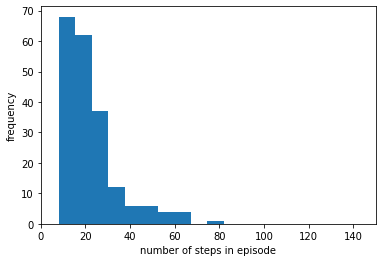

In [9]:
plt.hist(nStepsRandom)
plt.xlim(0, max_iter)
plt.xlabel('number of steps in episode')
plt.ylabel('frequency')
plt.show()

## Q-learning with neural networks

We now use Q-learning to train an agent how to move the cart around such that the pole stays upright.
Instead of a tabular approach, we will use a neural network.

### Model definition
The network will take the state information observed from the environenment via ```step.step(action)``` as input. As seen before, this is an array of four numbers. 
We can obtain the shape of the input tensor from ```env.observation_space.shape```.

The network has to predict which action to take. Since we have two actions, our action space has the dimension ```env.action_space.n```

We will use a small dense neural network with one hidden layer.


In [10]:
input_shape = env.observation_space.shape
n_output    = env.action_space.n

n_nodes = 32
batch_size = 32
optimizer = tf.keras.optimizers.Adam(lr=1E-3)
loss_fn = tf.keras.losses.mean_squared_error

# Q learning discount factor
discount_factor = 0.95

print('Input shape : {}'.format(input_shape))
print('Size of action space: {}'.format(n_output))

model = tf.keras.Sequential(name='DeepQ')
model.add(layers.Dense(units=n_nodes, activation=tf.nn.elu, input_shape=input_shape))
model.add(layers.Dense(units=n_nodes, activation=tf.nn.elu))
model.add(layers.Dense(units=n_output))

model.summary()


Input shape : (4,)
Size of action space: 2
Model: "DeepQ"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________


### Replay buffer

We now define the replay buffer in which we store all interactions with the environment. This helps to train the network more efficiently.

We also need to define a small helper function that samples the replay buffer and returns five arrays that contain the output of each ```env.step(action)``` command, i.e. ```state```, ```reward```, ```next_state```, ```done```, 
as well as the action we have taken when we executed ```env.step(action)```.
We will not store the debugging info in the replay buffer.


In [0]:
def sample_experience(batch_size = 32):
  #first we get a list of random indices to sample the replay buffer
  indices = np.random.randint(low = 0,
                              high = len(replay_buffer),
                              size = batch_size)
  #now we create a list containing a list of experiences from the environment 
  #of length batch_size
  batch = [replay_buffer[index] for index in indices]

  #then from each batch we access the individual experience tuple (state, action,
  #reward, done) and put these into five separate arrays
  states, actions, rewards, next_states, dones = [
    np.array( [ experience[i] for experience in batch])
    for i in range(0,5)
    ]
  return states, actions, rewards, next_states, dones

### Policy

We will use an $\epsilon$ greedy policy where we take the best known action according to the Q-value with probability $P = 1-\epsilon$ and choose an action at random with probability $\epsilon$ to explore how the environment reacts to the actions taken by the agent.


In [0]:
def policy(state, epsilon=0.0):
  if np.random.rand() < epsilon:
    return np.random.randint(2)
  else:
    # obtain the current best Q values from the DeepQ network
    Q_values = model.predict(state[np.newaxis])
    # take the action that results in the highest Q value
    return np.argmax(Q_values[0])



### Training step

We now need to define how we train the DeepQ network.

First we define a small helper function that executes one action, records the response from the environment in the replay buffer and returns it to the calling function

Then we define the main training loop were we define ourselves how the update rule for the Q-learning is used in supervised learning via gradient descent via ```GradientTape``` in TensorFlow.

The training target is defined according to the Q-value update rule as:
$$Q_{\mathrm{target}} = \mathrm{reward} + \mathrm{discount \, factor} \cdot \mathrm{max}_{a^\prime} Q_{\theta}(s^\prime, a^\prime)$$

Since the reward obtained per successful step where the pole does not tip over is quite simple (a constant reward $r=1$ is obtained), the sum of the rewards is simply the number of steps we can take in a single episode.
The highest this value gets, the better the DeepQ network is.
In order so retain the best model, we save the weights into the variable
```best_weights```

In [0]:
def play_one_step(env, state, epsilon):
  # get the action according to the epsilon-greedy policy
  action = policy(state, epsilon)

  # interact with the environment
  next_state, reward, done, info = env.step(action)

  #append experience to replay buffer
  replay_buffer.append((state, action, reward, next_state, done))

  return next_state, reward, done, info


def train(batch_size):
  # get a number of experiences from the replay buffer for training
  experiences = sample_experience(batch_size)
  states, actions, rewards, next_states, dones = experiences

  #use the DeepQ network to obtain Q-values for the next states
  # (remember that we always execute everything for batch_size number of experience tuples)
  next_Q_values = model.predict(next_states)

  #get the highest Q-value we can obtain for the next states
  max_next_Q_values = np.max(next_Q_values, axis = 1)

  # define training target
  target_Q_values = (rewards + (1 - dones)*discount_factor*max_next_Q_values)

  # the network will predict the Q-values for 
  target_Q_values = target_Q_values.reshape(-1, 1)

  # The DeepQ network will predict the Q-value for all possible actions
  # not just the one we used. So we create a mask that consists
  # of all the actions we have actually taken in the experiences we
  # obtained from the replay buffer. This mask can then be applied
  # to the prediction to obtain the Q-values to the actions we have taken
  # (and ignore the rest)
  mask = tf.one_hot(actions, n_output)

  # now do the gradient descent step
  with tf.GradientTape() as tape:
    #obtain predictions as tensor (instead of numpy arrays)
    all_Q_values = model(states)
    
    #apply the mask
    Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)

    # compute the loss function, i.e. the mean squared error
    # of the target values and the prediction (y_hat -y)^2
    loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

  # do the actual gradient descent by computing the gradient and
  # handing this to the optimizer to compute the next best values of the
  # network parameters (weights)  
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

Now do the actual training.
We fix the random seeds so that we always start from the same definition
of the environment, random numbers, etc.

The parameter $\epsilon$ of the greedy policy is decreased throughout the training. We start with a high value to sample the response from the environemnt and then decrease the value to exploit the optimal options as the Q-network learns.

In the beginning, the replay buffer is empty. 
We first use 50 "burn-in" iterations where we interact with the environment without network training to fill the buffer a bit so that the network has sufficient experiences to train on.

In [14]:
# setup a replay buffer
len_replay = 2000
replay_buffer = deque(maxlen=len_replay)

# fix the environment (ensure reproducibility between runs,
# remember to reset the model as well otherwise training
# will resume with the previous weights)
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = [] 
best_score = 0

for episode in range(600):
    obs = env.reset()    
    for step in range(200):

        # set the parameter for the epsilon greedy policy:
        # in the beginning, the network needs to explore a lot, hence 
        # epsilon is fairly high. As the training progresses, we decrease
        # the exploratory phase and favor the exploitation.
        epsilon = max(1 - episode / 500, 0.01)

        # execute the action, and add to replay buffer (see function earlier)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break

    # since a constant reward is obtained, the cumulative reward is 
    # simply the number of steps we managed to hold the pole up.
    rewards.append(step) 

    # keep the best performing network that manages to keep the pole up/
    if step > best_score: 
        best_weights = model.get_weights() 
        best_score = step 
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="")

    # the replay buffer is empty at the beginning. Fill the replay buffer
    # by running for 50 episodes as "burn in" without training first.
    if episode > 50:
        train(batch_size)

#use the best model we have encountered during training.
model.set_weights(best_weights)

Episode: 599, Steps: 22, eps: 0.010

Let's have a look at the training process.
In reinforcement learning, the loss function is typically not a good indicator of how well the network performs.

Instead, we look at the cumulative reward, in this case, the length of the episode  until the pole tipped over.

We notice a distinct structure where the network obtains a high reward  - followed by sequences of a very low reward. This is called "catastrophic forgetting" and one of the big challenges in neural network based reinforcement learning.

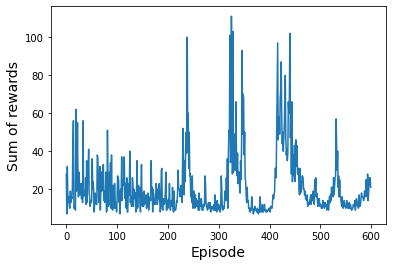

In [15]:
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()

At this point we save the model into a single file in H5 format.
(alternatively, we could use the TensorFlow format. However, this creates multiple directories and files which is not as practical if we want to move the model to a different environment.

We can also load the model from the same file.

In [18]:
# save the entire model in a single H5 file
#model.save('CartPoleModel.h5')

#load the model
#model = tf.keras.models.load_model('CartPoleModel.h5')

assets	CartPoleModel  CartPoleModel.h5  sample_data  saved_model.pb  variables


## Run the Agent

Now we use the network to predict which action the agent should take.

Let's first look at a little animation

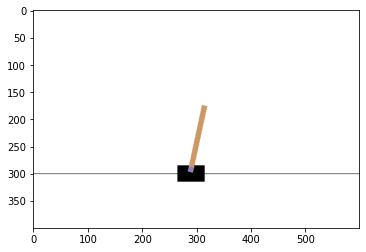

Timestep: 96
State   : [-0.08194565  0.57329455  0.21177855  0.17731596]
Action  : 1
Reward  : 1.0
Done    : True


In [19]:
frames = []
state  = env.reset()

for i in range(max_iter):

  #choose optimal action
  action = policy(state)
  new_state, reward, done, info = env.step(action)
  state = new_state



  frames.append({
      'frame'  : env.render(mode='rgb_array'),
      'state'  : state,
      'action' : action,
      'reward' : reward,
      'done'   : done
  })

  if done:
    break

for i, frame in enumerate(frames):
  clear_output(wait=True)
  plt.imshow((frame['frame']))
  plt.show()
  print(f"Timestep: {i}")
  print(f"State   : {frame['state']}")
  print(f"Action  : {frame['action']}")
  print(f"Reward  : {frame['reward']}")
  print(f"Done    : {frame['done']}")

Let's now run the agent for 200 episodes and look at the distribution of the highest rewards, i.e. the number of steps we managed to hold the pole upright.

This is considerably better than what we obtained earlier when just choosing an action at random.

In [0]:
nStepsDQN = []

for episode in range(0,200):
  env.reset()
  for i in range(max_iter):
    action = policy(state)
    new_state, reward, done, info = env.step(action)
    state = new_state

    if done:
      nStepsDQN.append(i)
      break



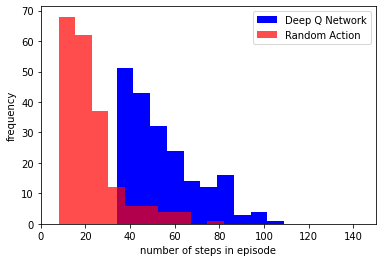

In [21]:
plt.hist(nStepsDQN, label='Deep Q Network', color='blue')
plt.hist(nStepsRandom, label='Random Action', color='red', alpha=0.7)
plt.xlim(0,150)
plt.xlabel('number of steps in episode')
plt.ylabel('frequency')
plt.legend()
plt.show()